This notebook illustrates the following on CLIP extracted features of Imagenette v2 dataset


*   Classification using MLP using flax+JAX
*   Logistic Regression using flax+JAX
*   Logistic Regression using sklearn
*   Logistic Regression using pytorch-lightning


---


Author: Gerardo Durán-Martín (@gerdm). Based on work by Srikar-Reddy-Jilugu (@always-newbie161)






In [1]:
import jax
jax.numpy.sqrt(2)

DeviceArray(1.4142135, dtype=float32)

### Required Installations

make these dirs just to be consistent with the original repo

In [2]:
!mkdir data
!mkdir notebooks
%cd notebooks

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘notebooks’: File exists
/home/gerardoduran/documents/misc/2021-08/notebooks


Getting the clip_dataloader.py for pyprobml which gets the dataloaders for **CLIP extracted fetures** of imagenette v2 dataset

In [3]:
!wget -qN https://raw.githubusercontent.com/probml/pyprobml/master/scripts/clip_dataloader.py
!pip install -q flax pytorch-lightning wget superimport

### Downloading original Imagenette dataset

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds

try:
  data, info = tfds.load("imagenette/160px-v2", with_info=True, as_supervised=True)
except:
  data, info = tfds.load("imagenette/160px-v2", with_info=True, as_supervised=True)

train_data, test_data = data['train'], data['validation']

In [7]:
print(info)

tfds.core.DatasetInfo(
    name='imagenette',
    full_name='imagenette/160px-v2/1.0.0',
    description="""
    Imagenette is a subset of 10 easily classified classes from the Imagenet
    dataset. It was originally prepared by Jeremy Howard of FastAI. The objective
    behind putting together a small version of the Imagenet dataset was mainly
    because running new ideas/algorithms/experiments on the whole Imagenet take a
    lot of time.
    
    This version of the dataset allows researchers/practitioners to quickly try out
    ideas and share with others. The dataset comes in three variants:
    
      * Full size
      * 320 px
      * 160 px
    
    Note: The v2 config correspond to the new 70/30 train/valid split (released
    in Dec 6 2019).
    """,
    config_description="""
    160px variant.
    """,
    homepage='https://github.com/fastai/imagenette',
    data_path='/home/gerardoduran/tensorflow_datasets/imagenette/160px-v2/1.0.0',
    download_size=94.42 MiB,
    datas

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt
from clip_dataloader import get_imagenette_clip_loaders

Getting the CLIP-extracted data for the Imagenette dataset.

In [9]:
# zip files of the data will be stored in "dir_name" directory.
train_loader, test_loader = get_imagenette_clip_loaders(dir_name='../data')

def convert_dataloader_to_numpy(loader):
    features, labels = [], []

    for batch in loader:
        features.append(batch[0])
        labels.append(batch[1])

    features, labels = np.concatenate(features), np.concatenate(labels)

    return features, labels

train_features, train_labels = convert_dataloader_to_numpy(train_loader)
test_features, test_labels = convert_dataloader_to_numpy(test_loader)

size of training_data: features:torch.Size([9469, 512]), labels:(9469,)
size of testing_data: features:torch.Size([3925, 512]), labels:(3925,)


In [10]:
import csv
import requests
from io import StringIO
class_names_url = "https://raw.githubusercontent.com/probml/probml-data/main/data/imagenette_class_names.csv"

r = requests.get(class_names_url)

In [11]:
csv_reader = csv.reader(StringIO(r.text))
# Skip first row
next(csv_reader)
class_names = {int(ix): label for ix, label in csv_reader}

for ix, label in class_names.items():
    print(ix, label)

0 tench_tinca
1 english_springer
2 cassette_player
3 chain_saw
4 church_building
5 french_horn
6 garbage_truck
7 gas_pump
8 golf_ball
9 parachute


## Splitting classes

In this first test, we choose two classes and try to distinguish them

In [12]:
import jax
import jax.numpy as jnp
from jax import random
from jax.scipy.optimize import minimize

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [13]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [14]:
all_classes = set(class_names.keys())
positive_classes = {0, 1}
negative_classes = all_classes - positive_classes

In [15]:
positive_class = 0
negative_class = 9

train_map = (train_labels == positive_class) | (train_labels == negative_class)
test_map = (test_labels == positive_class) | (test_labels == negative_class)

train_labels_binary = train_labels[train_map]
test_labels_binary = test_labels[test_map]

positive_where = train_labels_binary == positive_class
negative_where = train_labels_binary == negative_class
train_labels_binary[positive_where] = 1.0
train_labels_binary[negative_where] = 0.0

positive_where = test_labels_binary == positive_class
negative_where = test_labels_binary == negative_class
test_labels_binary[positive_where] = 1.0
test_labels_binary[negative_where] = 0.0

In [16]:
Phi = train_features[train_map]
N, M = Phi.shape
Phi = jnp.c_[jnp.ones(N), Phi]
M += 1

In [17]:
Phi_test = test_features[test_map]
N_test, M = Phi_test.shape
Phi_test = jnp.c_[jnp.ones(N_test), Phi_test]
M += 1

## Laplace approximation

In [18]:
def accuracy_logreg(X, weights, y):
    y_proba = sigmoid(X @ weights)
    y_pred = y_proba > 0.5
    return (y_pred == y).mean()

In [20]:
%%time
key = random.PRNGKey(31415)
init_noise = 0.1
w0 = random.multivariate_normal(key, jnp.zeros(M), jnp.eye(M) * init_noise) * 0
w0 = np.random.randn(M) * 0
alpha = 1.0

def sigmoid(x): return jnp.exp(x) / (1 + jnp.exp(x))
def log_sigmoid(x): return x - jnp.log(1 + jnp.exp(x))

def fz(x): return x
def fx(w, x): return sigmoid(w[None, :] @ x)
def Rt(w, x): return sigmoid(w @ x) * (1 - sigmoid(w @ x))

y = train_labels_binary.copy()
def E(w):
    an = Phi @ w
    log_an = log_sigmoid(an)
    log_likelihood_term = y * log_an + (1 - y) * jnp.log1p(-sigmoid(an))
    prior_term = alpha * w @ w / 2

    return prior_term - log_likelihood_term.sum()

res = minimize(lambda x: E(x) / len(y), w0, method="BFGS", tol=1e-5)
w_laplace = res.x
SN = jax.hessian(E)(w_laplace)
res.success

CPU times: user 9.22 s, sys: 1.26 s, total: 10.5 s
Wall time: 3.01 s


DeviceArray(True, dtype=bool)

In [21]:
y_test_pred_proba = sigmoid(Phi_test @ w_laplace)
y_test_pred = y_test_pred_proba > 0.5
(test_labels_binary == y_test_pred).mean()

DeviceArray(1., dtype=float32)

In [22]:
confusion_matrix(test_labels_binary, y_test_pred)

array([[390,   0],
       [  0, 387]])

# EKF

In [ ]:
# Use latest version of nlds_lib
#!wget -qN https://raw.githubusercontent.com/probml/pyprobml/master/scripts/nlds_lib.py

In [23]:
import nlds_lib as ds
from importlib import reload

reload(ds)

<module 'nlds_lib' from '/home/gerardoduran/documents/misc/2021-08/nlds_lib.py'>

In [24]:
mu_t = jnp.zeros(M)
Pt = jnp.eye(M) * 0.0
P0 = jnp.eye(M) * 2.0

model = ds.ExtendedKalmanFilter(fz, fx, Pt, Rt)
w_eekf_hist, P_eekf_hist = model.filter(mu_t, y, (Phi,), P0)

w_eekf = w_eekf_hist[-1]
P_eekf = P_eekf_hist[-1]

In [25]:
y_test_pred_proba = sigmoid(Phi_test @ w_eekf)
y_test_pred = y_test_pred_proba > 0.5
confusion_matrix(test_labels_binary, y_test_pred)

ValueError: matmul input operand 1 must have ndim at least 1, but it has ndim 0

In [ ]:
accuracy_logreg(Phi_test, w_eekf, test_labels_binary)

In [ ]:
accuracy_vmap = jax.vmap(lambda w: accuracy_logreg(Phi_test, w, test_labels_binary))
accuracy_hist = accuracy_vmap(w_eekf_hist)
plt.plot(np.arange(1, N+1), accuracy_hist)

plt.ylabel("accuracy")
plt.xlabel("number datapoints")
plt.title("Accuracy over time", fontsize=12);

# 10-class Imagenette

## MCMC Posterior estimation

In [26]:
!pip install -q git+https://github.com/blackjax-devs/blackjax.git
!pip install -q git+git://github.com/deepmind/distrax.git

In [27]:
import blackjax.rwmh as mh
import blackjax.nuts as nuts
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

In [28]:
Phi = train_features
N, M = Phi.shape
Phi = jnp.c_[jnp.ones(N), Phi]
M += 1

In [29]:
Y = ohe.fit_transform(train_labels[:, None])
N, K = Y.shape

M * K

5130

In [30]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [31]:
def E(W):
    W = W.reshape(K,M)
    # 1. Prior term
    wk_terms = alpha / 2 * jnp.einsum("ki,ki->", W, W)
    # 2. Log-Sum-Exp terms w/ trick
    activations = jnp.einsum("ki,ni->kn", W, Phi)
    activations_star = activations.max(axis=0, keepdims=True)
    activations = activations - activations_star
    lse = activations_star.ravel() + jnp.log(jnp.exp(activations).sum(axis=0))
    # 3. Dot product terms
    dot_product = jnp.einsum("nk,km,nm->", Y, W, Phi)

    energy = wk_terms + lse.sum() - dot_product
    return energy

In [32]:
key = random.PRNGKey(31415)

alpha = 1.0
w0_mean = jnp.zeros(M)
S0 = alpha * jnp.eye(M)
w0 = random.multivariate_normal(key, w0_mean, S0, shape=(K,)).ravel()

In [33]:
%%time
sigma_mcmc = 0.07
initial_state = mh.new_state(w0, E)
mcmc_kernel = mh.kernel(E, jnp.ones(K * M) * sigma_mcmc)
mcmc_kernel = jax.jit(mcmc_kernel)

key_init = jax.random.PRNGKey(0)
nsamples = 10_000
states = inference_loop(key_init, mcmc_kernel, initial_state, nsamples)

CPU times: user 3min 35s, sys: 19.2 s, total: 3min 55s
Wall time: 18.2 s


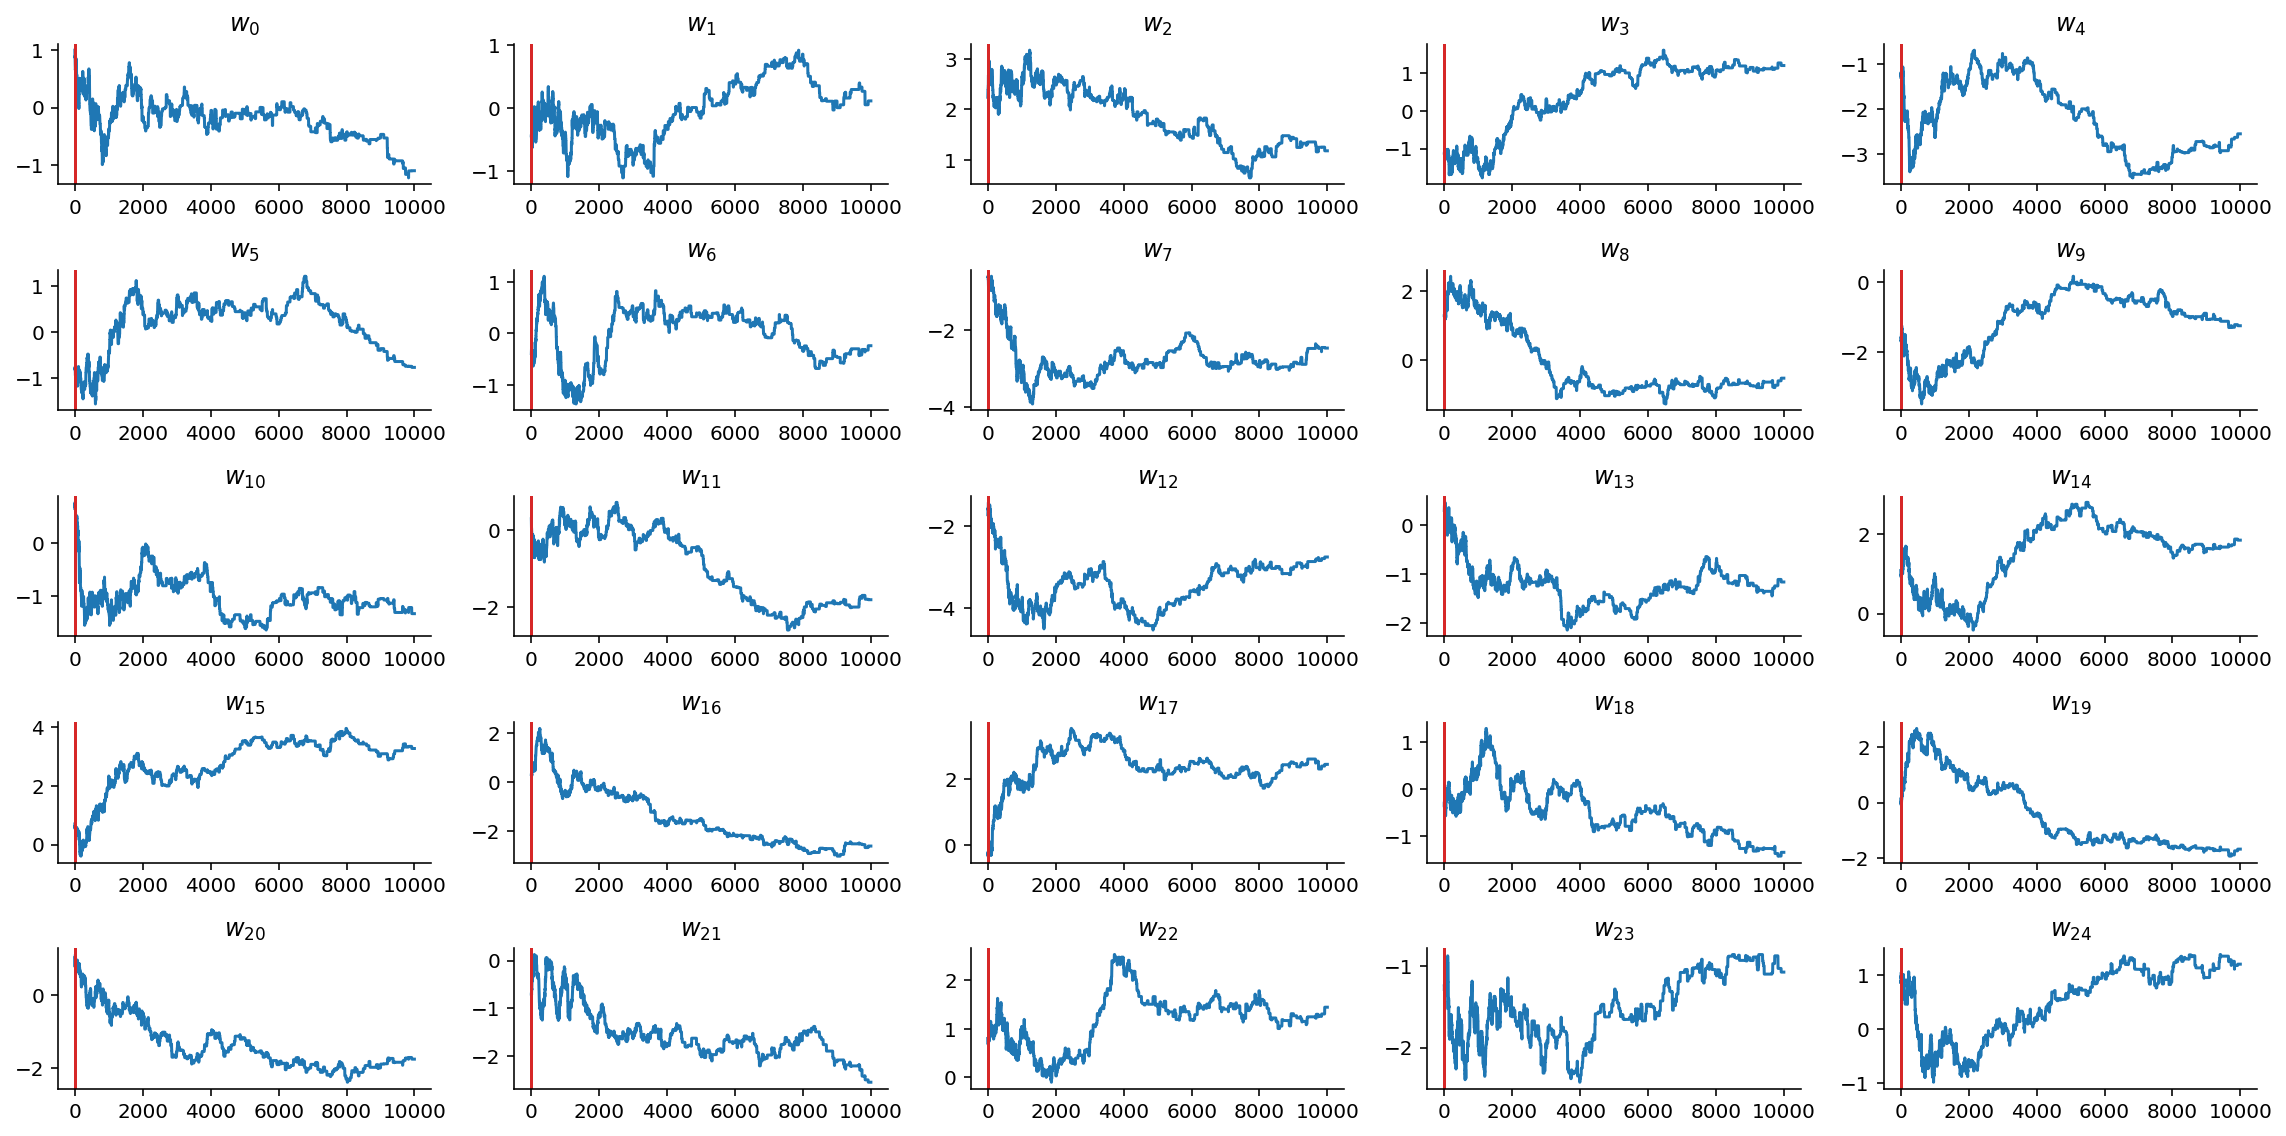

In [34]:
burnin = 0

fig, ax = plt.subplots(5, 5, figsize=(16, 8))
ax = ax.ravel()
for i, axi in enumerate(ax):
    axi.plot(states.position[:, i])
    axi.set_title("$w_{"f"{i}""}$")
    axi.axvline(x=burnin, c="tab:red")
plt.tight_layout()
plt.show()


In [175]:
%%time
step_size = 1e-3
inv_mass_matrix = 0.5 * jnp.ones(M * K)

initial_state = nuts.new_state(w0, E)
nuts_kernel = nuts.kernel(E, step_size, inv_mass_matrix)
nuts_kernel = jax.jit(nuts_kernel)

key_init = jax.random.PRNGKey(0)
nsamples = 1500

states = inference_loop(key_init, nuts_kernel, initial_state, nsamples)

CPU times: user 11h 48min 29s, sys: 41min 59s, total: 12h 30min 28s
Wall time: 50min 30s


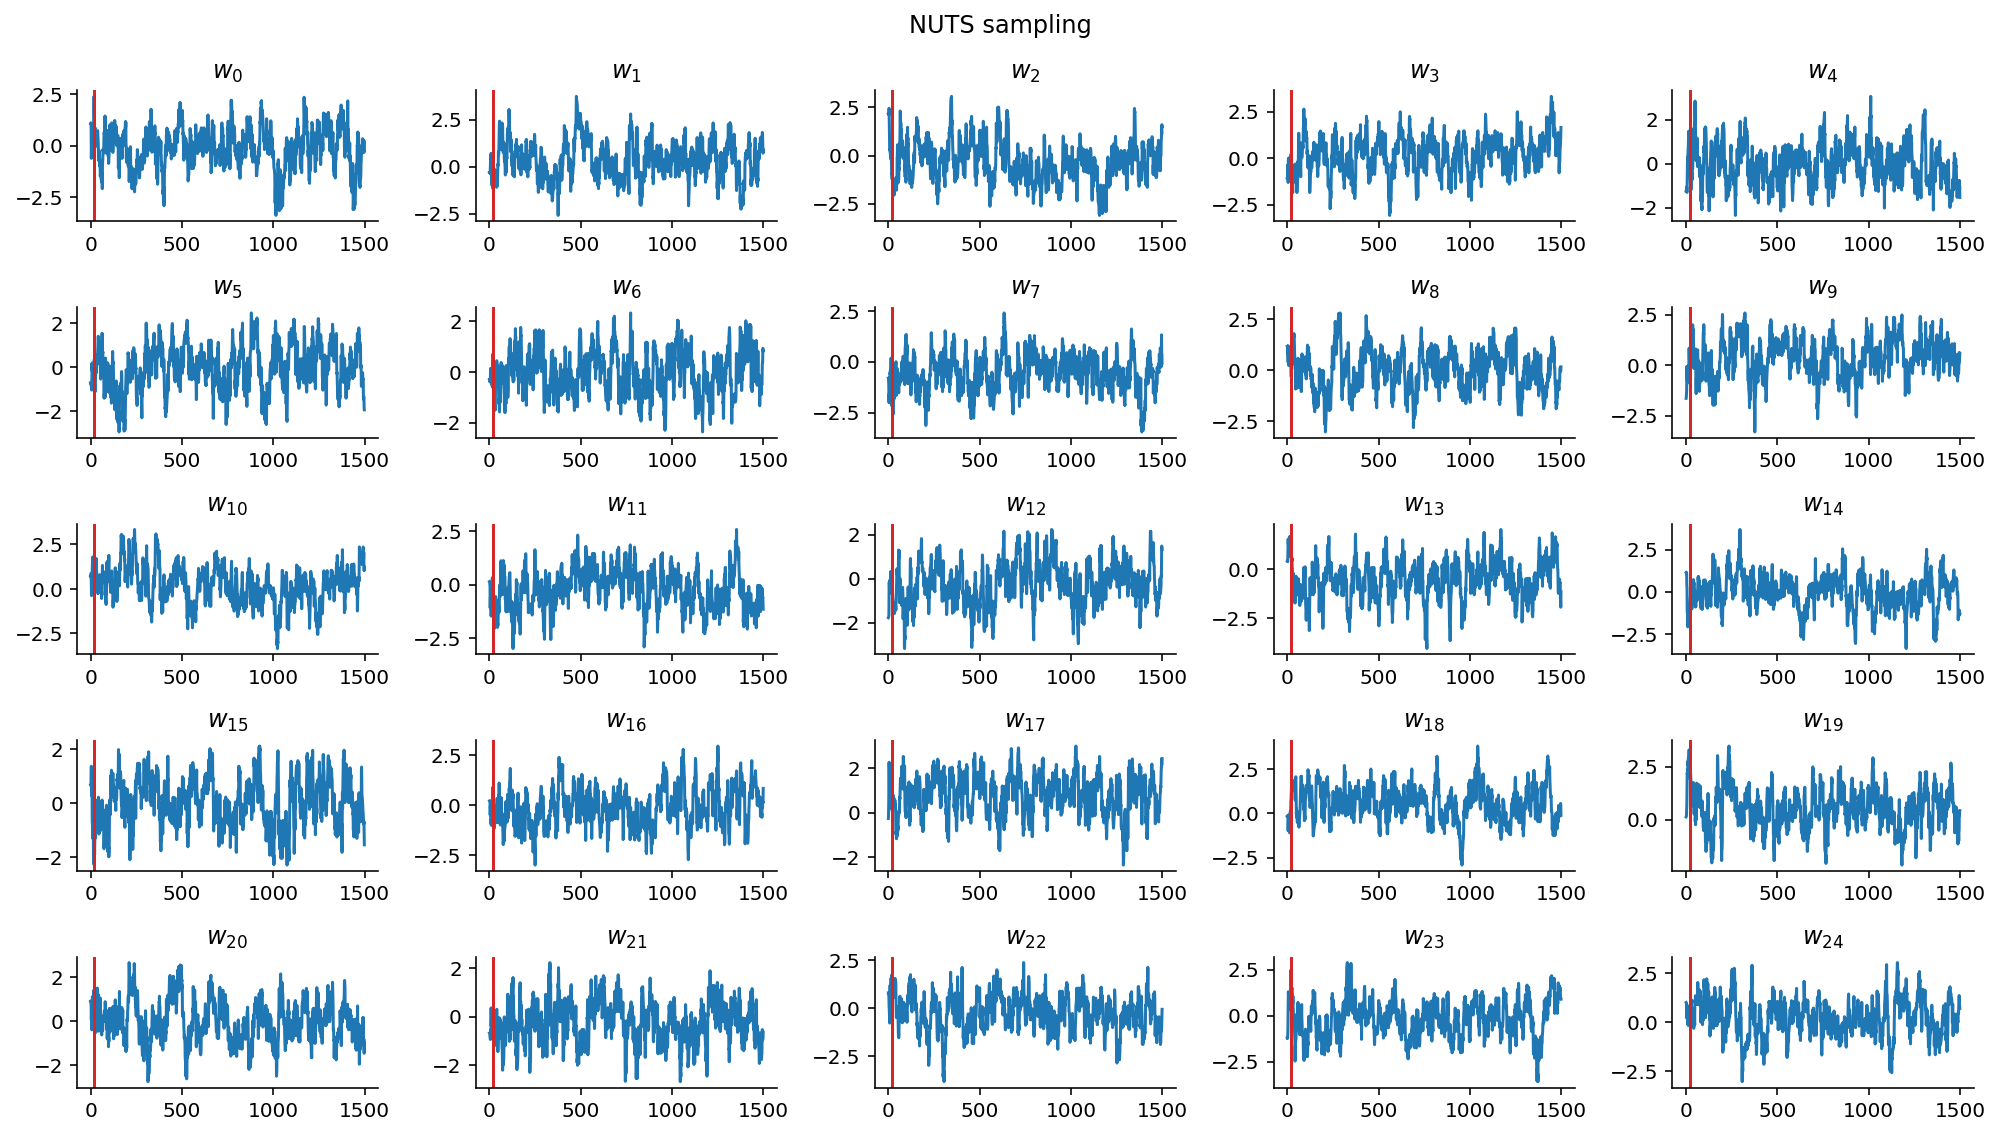

In [179]:
burnin = 20

fig, ax = plt.subplots(5, 5, figsize=(14, 8))
ax = ax.ravel()
for i, axi in enumerate(ax):
    axi.plot(states.position[:, i])
    axi.set_title("$w_{"f"{i}""}$")
    axi.axvline(x=burnin, c="tab:red")
plt.suptitle("NUTS sampling")
plt.savefig("nuts-multinomial.jpeg", transparent=True)
plt.tight_layout()
plt.show()

In [181]:
chains = states.position[burnin:, :]
# Samples, classes, parameters per class
chains = chains.reshape(-1, K, M)
nsamp, *_ = chains.shape
chains.shape

(1480, 10, 513)

In [39]:
# jnp.save("multinomial.npy", chains)
chains = jnp.load("multinomial.npy")
chains.shape

(1480, 10, 513)

In [182]:
Phi_test = test_features
N_test, M = Phi_test.shape
Phi_test = jnp.c_[jnp.ones(N_test), Phi_test]
M += 1

In [183]:
import distrax
from jax.nn import softmax

activation_chains = jnp.einsum("skm,nm->nks", chains, Phi_test)
probs = softmax(activation_chains, axis=1).mean(axis=-1)

In [184]:
probs.argmax(axis=-1)

DeviceArray([9, 3, 2, ..., 5, 4, 1], dtype=int32)

In [43]:
confusion_matrix(test_labels, probs.argmax(axis=-1))

array([[384,   0,   0,   3,   0,   0,   0,   0,   0,   0],
       [  0, 394,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0, 349,   4,   0,   0,   1,   2,   1,   0],
       [  0,   0,   1, 382,   0,   1,   1,   1,   0,   0],
       [  0,   0,   0,   0, 409,   0,   0,   0,   0,   0],
       [  0,   0,   1,   4,   2, 387,   0,   0,   0,   0],
       [  0,   0,   0,   1,   0,   0, 387,   1,   0,   0],
       [  0,   0,   0,   4,   0,   0,   0, 414,   0,   1],
       [  0,   0,   0,   0,   1,   0,   0,   2, 395,   1],
       [  0,   1,   0,   3,   0,   1,   0,   0,   0, 385]])

## Multinomial training with EEKF

In [44]:
reload(ds)

<module 'nlds_lib' from '/home/gerardoduran/documents/misc/2021-08/nlds_lib.py'>

In [54]:
from jax.nn import softmax
from jax.ops import index_update

K = len(jnp.unique(train_labels))

def fz(W): return W

def fx(W, x):
    W = W.reshape(K,M)
    activations = jnp.einsum("km,m->k", W, x)
    probs = softmax(activations)
    return probs

def Rt(W, x):
    probs = fx(W, x)
    W = W.reshape(K, M)
    activations = jnp.einsum("km,m->k", W, x)
    probs = softmax(activations)

    diag_ix = jnp.diag_indices(K)
    cov = -probs[:, None] @ probs[None, :]
    cov = index_update(cov, diag_ix, probs * (1 - probs))    
    return cov

In [152]:
mu_t = jnp.zeros(M * K)
Pt = jnp.eye(M * K) * 0.0
model = ds.ExtendedKalmanFilter(fz, fx, Pt, Rt)

In [180]:
Y.shape

(9469, 10)

In [172]:
%%time
P0 = jnp.eye(M * K) * 0.1
n_train = 200
w_eekf, P_eekf = model.filter(mu_t, Y[:n_train], (Phi[:n_train],), P0)

CPU times: user 52min 59s, sys: 6.18 s, total: 53min 5s
Wall time: 1min 15s


In [173]:
# Shape (K, M)
W = w_eekf.reshape(K, M)
y_test_pred = softmax(jnp.einsum("km,nm->nk", W, Phi_test)).argmax(axis=-1)
y_test_pred

DeviceArray([9, 3, 2, ..., 5, 4, 1], dtype=int32)

In [174]:
confusion_matrix(test_labels, y_test_pred)

array([[381,   1,   0,   5,   0,   0,   0,   0,   0,   0],
       [  6, 388,   0,   1,   0,   0,   0,   0,   0,   0],
       [  1,   0, 307,  23,   0,  13,   2,   8,   3,   0],
       [  1,   1,   1, 369,   1,   3,   6,   3,   1,   0],
       [  0,   0,   0,   0, 409,   0,   0,   0,   0,   0],
       [  1,   0,   0,   6,   3, 381,   0,   0,   3,   0],
       [  0,   0,   0,   5,   1,   0, 377,   6,   0,   0],
       [  0,   0,  45,   9,   3,   2,   8, 352,   0,   0],
       [  0,   1,   1,   8,   2,   0,   0,   0, 386,   1],
       [  2,   2,   0,   5,   2,   3,   0,   1,   2, 373]])